# Notebook: The battle of Toronto vs New York

### Let's extract the neighborhood data first

In [1]:
# import libraries
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import requests

import json

from geopy.geocoders import Nominatim
from pandas.io.json import json_normalize

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline

# import k-means
from sklearn.cluster import KMeans

import folium

print('All library is imported!')

All library is imported!


In [417]:
# Scrapping Toronto neighborhoods from website and save to dataframe
html_source = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').text
soup = BeautifulSoup(html_source, 'lxml')

table = soup.find('table')

tablelist = []
for element in table.find_all('tr'):
    tablelist.append(element.text.split('\n')[1:4])

toronto_df = pd.DataFrame(tablelist)
toronto_df.columns = toronto_df.iloc[0].values
toronto_df = toronto_df[1:]
toronto_df.rename(columns={'Neighbourhood':'Neighborhood'}, inplace=True)

# drop not assigned borough
toronto_df.drop(toronto_df[toronto_df['Borough'] == 'Not assigned'].index, inplace=True)

# merge neighborhoods with same borough
toronto_df = toronto_df.groupby(['Postcode','Borough'])['Neighborhood'].apply(','.join).reset_index()

# insert geospatial_data from csv file
geospatial_data = pd.read_csv('Geospatial_data.csv')
geospatial_data.rename(columns={'Postal Code':'Postcode'}, inplace=True)

# and merge to dataframe
toronto_df = pd.merge(toronto_df, geospatial_data, on='Postcode')

# drop Postcode column
toronto_df.drop('Postcode', axis=1, inplace=True)

print(toronto_df.shape)
toronto_df.head()

(103, 4)


,Borough,Neighborhood,Latitude,Longitude
0,Scarborough,"Rouge,Malvern",43.806686,-79.194353
1,Scarborough,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497
2,Scarborough,"Guildwood,Morningside,West Hill",43.763573,-79.188711
3,Scarborough,Woburn,43.770992,-79.216917
4,Scarborough,Cedarbrae,43.773136,-79.239476


In [418]:
# Getting data of newyork neighborhoods from csv
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)
    
neighborhoods_data = newyork_data['features']

column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude']

newyork_df = pd.DataFrame(columns=column_names)

for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough']
    neighborhood_name = data['properties']['name']
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]    
    newyork_df = newyork_df.append({'Borough': borough,
                       'Neighborhood': neighborhood_name,
                       'Latitude': neighborhood_lat,
                       'Longitude': neighborhood_lon}, ignore_index=True)
print(newyork_df.shape)
newyork_df.head()

(306, 4)


,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


### Now let's do some analysis for Toronto using foursquare API

In [4]:
# map of toronto
toronto_addr = 'Toronto, ON'

to_locator = Nominatim(user_agent="to_explorer")
location= to_locator.geocode(toronto_addr)
latitude = location.latitude
longitude = location.longitude

map_toronto = folium.Map(location=[latitude, longitude], zoom_axis = 12)

# add the neighborhoods
for lat,lng,borough,name in zip(toronto_df['Latitude'], toronto_df['Longitude'], toronto_df['Borough'], toronto_df['Neighborhood']):
    label = '{}, {}'.format(name, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat,lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto) 

map_toronto

### Connecting with my foursquare account to retrieve the neighborhood data

We try to take the first neighborhood in Toronto

In [5]:
neighborhood_lat = toronto_df.loc[0, 'Latitude']
neighborhood_lon = toronto_df.loc[0, 'Longitude']
neighborhood_name = toronto_df.loc[0, 'Neighborhood']

print('Toronto neighborhood {} is located at {},{}' .format(neighborhood_name, neighborhood_lat, neighborhood_lon))

Toronto neighborhood Rouge,Malvern is located at 43.806686299999996,-79.19435340000001


In [6]:
import os

CLIENT_ID = os.environ.get('FOURSQUARE_ID') # your Foursquare ID
CLIENT_SECRET = os.environ.get('FOURSQUARE_SECRET') # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

LIMIT = 100

radius = 500

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_lat, 
    neighborhood_lon, 
    radius, 
    LIMIT)

In [7]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [8]:
nh_result = requests.get(url).json()

venues = nh_result['response']['groups'][0]['items']
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]
# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)
# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues

,name,categories,lat,lng
0,Wendy's,Fast Food Restaurant,43.807448,-79.199056


It seems that this neighborhood only has 1 Wendy's restaurant in 500m radius.

Now let's try to do the same thing but for **all neighborhoods** in Toronto

In [9]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    venues_list = []
    
    for name, lat, lon in zip(names,latitudes,longitudes):
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lon, 
            radius, 
            LIMIT)
        
        results = requests.get(url).json()["response"]['groups'][0]['items']
        venues_list.append([(
            name, 
            lat, 
            lon, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
        
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [10]:
toronto_venues = getNearbyVenues(names = toronto_df['Neighborhood'],
                                 latitudes = toronto_df['Latitude'],
                                 longitudes = toronto_df['Longitude'])

I don't know how, but the Neighborhood column is already exist so we have to remove it

In [74]:
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")
toronto_onehot.drop('Neighborhood', axis=1,inplace=True)

In [75]:
toronto_onehot.insert(0, 'Neighborhood', toronto_venues['Neighborhood'])
toronto_onehot.head()

,Neighborhood,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,"Rouge,Malvern",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"Highland Creek,Rouge Hill,Port Union",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"Guildwood,Morningside,West Hill",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"Guildwood,Morningside,West Hill",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"Guildwood,Morningside,West Hill",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [77]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped

,Neighborhood,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,"Adelaide,King,Richmond",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.02,0.0,...,0.0,0.02,0.0,0.000000,0.0,0.0,0.01,0.0,0.0,0.0
1,Agincourt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.0,0.00,0.0,0.000000,0.0,0.0,0.00,0.0,0.0,0.0
2,"Agincourt North,L'Amoreaux East,Milliken,Steel...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.0,0.00,0.0,0.000000,0.0,0.0,0.00,0.0,0.0,0.0
3,"Albion Gardens,Beaumond Heights,Humbergate,Jam...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.0,0.00,0.0,0.111111,0.0,0.0,0.00,0.0,0.0,0.0
4,"Alderwood,Long Branch",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.0,0.00,0.0,0.000000,0.0,0.0,0.00,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Willowdale West,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.0,0.00,0.0,0.000000,0.0,0.0,0.00,0.0,0.0,0.0
96,Woburn,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.0,0.00,0.0,0.000000,0.0,0.0,0.00,0.0,0.0,0.0
97,"Woodbine Gardens,Parkview Hill",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.0,0.00,0.0,0.000000,0.0,0.0,0.00,0.0,0.0,0.0
98,Woodbine Heights,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,...,0.0,0.00,0.0,0.111111,0.0,0.0,0.00,0.0,0.0,0.0


Now check the venues in Toronto

In [80]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:num_top_venues]

In [111]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

columns = ['Neighborhood']

for i in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue' .format(i+1,indicators[i]))
    except:
        columns.append('{}th Most Common Venue' .format(i+1))

to_venues_sorted = pd.DataFrame(columns = columns)
to_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']
for i in np.arange(toronto_grouped.shape[0]):
    to_venues_sorted.iloc[i,1:] = return_most_common_venues(toronto_grouped.iloc[i,:], num_top_venues)

to_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,"Adelaide,King,Richmond",Coffee Shop,Café,Bar,Steakhouse,Sushi Restaurant
1,Agincourt,Latin American Restaurant,Lounge,Breakfast Spot,Skating Rink,Yoga Studio
2,"Agincourt North,L'Amoreaux East,Milliken,Steel...",Park,Playground,Doner Restaurant,Department Store,Dessert Shop
3,"Albion Gardens,Beaumond Heights,Humbergate,Jam...",Grocery Store,Video Store,Sandwich Place,Beer Store,Pizza Place
4,"Alderwood,Long Branch",Pizza Place,Coffee Shop,Gym,Skating Rink,Pharmacy
...,...,...,...,...,...,...
95,Willowdale West,Home Service,Butcher,Grocery Store,Coffee Shop,Pharmacy
96,Woburn,Coffee Shop,Korean Restaurant,Yoga Studio,Drugstore,Diner
97,"Woodbine Gardens,Parkview Hill",Fast Food Restaurant,Pizza Place,Gym / Fitness Center,Café,Intersection
98,Woodbine Heights,Curling Ice,Asian Restaurant,Skating Rink,Park,Video Store


### Clustering Toronto Neighborhood

In [110]:
kclusters = 5

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', axis=1)
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

kmeans.labels_

array([1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 0, 1, 1, 2, 1, 1, 1, 2, 1, 1,
       1, 2, 1, 1, 1, 1, 1, 2, 2, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2], dtype=int32)

In [112]:
to_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
to_venues_sorted

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,1,"Adelaide,King,Richmond",Coffee Shop,Café,Bar,Steakhouse,Sushi Restaurant
1,1,Agincourt,Latin American Restaurant,Lounge,Breakfast Spot,Skating Rink,Yoga Studio
2,2,"Agincourt North,L'Amoreaux East,Milliken,Steel...",Park,Playground,Doner Restaurant,Department Store,Dessert Shop
3,1,"Albion Gardens,Beaumond Heights,Humbergate,Jam...",Grocery Store,Video Store,Sandwich Place,Beer Store,Pizza Place
4,1,"Alderwood,Long Branch",Pizza Place,Coffee Shop,Gym,Skating Rink,Pharmacy
...,...,...,...,...,...,...,...
95,1,Willowdale West,Home Service,Butcher,Grocery Store,Coffee Shop,Pharmacy
96,1,Woburn,Coffee Shop,Korean Restaurant,Yoga Studio,Drugstore,Diner
97,1,"Woodbine Gardens,Parkview Hill",Fast Food Restaurant,Pizza Place,Gym / Fitness Center,Café,Intersection
98,1,Woodbine Heights,Curling Ice,Asian Restaurant,Skating Rink,Park,Video Store


In [138]:
to_merged = toronto_df
to_merged = to_merged.join(to_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

# dropna
to_merged = to_merged.dropna().reset_index(drop=True)
to_merged['Cluster Labels'] = to_merged['Cluster Labels'].astype('int')
to_merged

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Scarborough,"Rouge,Malvern",43.806686,-79.194353,1,Fast Food Restaurant,Department Store,Event Space,Ethiopian Restaurant,Empanada Restaurant
1,Scarborough,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497,3,Bar,Yoga Studio,Donut Shop,Dim Sum Restaurant,Diner
2,Scarborough,"Guildwood,Morningside,West Hill",43.763573,-79.188711,1,Mexican Restaurant,Intersection,Electronics Store,Breakfast Spot,Rental Car Location
3,Scarborough,Woburn,43.770992,-79.216917,1,Coffee Shop,Korean Restaurant,Yoga Studio,Drugstore,Diner
4,Scarborough,Cedarbrae,43.773136,-79.239476,1,Bakery,Gas Station,Hakka Restaurant,Fried Chicken Joint,Caribbean Restaurant
...,...,...,...,...,...,...,...,...,...,...
95,York,Weston,43.706876,-79.518188,2,Park,Donut Shop,Dessert Shop,Dim Sum Restaurant,Diner
96,Etobicoke,Westmount,43.696319,-79.532242,1,Pizza Place,Middle Eastern Restaurant,Coffee Shop,Sandwich Place,Intersection
97,Etobicoke,"Kingsview Village,Martin Grove Gardens,Richvie...",43.688905,-79.554724,2,Park,Pizza Place,Bus Line,Mobile Phone Shop,Dog Run
98,Etobicoke,"Albion Gardens,Beaumond Heights,Humbergate,Jam...",43.739416,-79.588437,1,Grocery Store,Video Store,Sandwich Place,Beer Store,Pizza Place


In [146]:
# create map
toronto_addr = 'Toronto, ON'

to_locator = Nominatim(user_agent="to_explorer")
location= to_locator.geocode(toronto_addr)
latitude = location.latitude
longitude = location.longitude

map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(to_merged['Latitude'], to_merged['Longitude'], to_merged['Neighborhood'], to_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

As we can see, most of the neighborhoods in Toronto are homogeneous. In what way these neighborhoods are similar?

Check the Cluster 0

In [163]:
to_merged.loc[to_merged['Cluster Labels'] == 0, to_merged.columns[[1]+list(range(5, to_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
89,"Humber Bay,King's Mill Park,Kingsway Park Sout...",Locksmith,Baseball Field,Yoga Studio,Drugstore,Diner
94,"Emery,Humberlea",Paper / Office Supplies Store,Furniture / Home Store,Baseball Field,Department Store,Dim Sum Restaurant


Now check the Cluster 1, which is the majority

In [164]:
to_merged.loc[to_merged['Cluster Labels'] == 1, to_merged.columns[[1]+list(range(5, to_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,"Rouge,Malvern",Fast Food Restaurant,Department Store,Event Space,Ethiopian Restaurant,Empanada Restaurant
2,"Guildwood,Morningside,West Hill",Mexican Restaurant,Intersection,Electronics Store,Breakfast Spot,Rental Car Location
3,Woburn,Coffee Shop,Korean Restaurant,Yoga Studio,Drugstore,Diner
4,Cedarbrae,Bakery,Gas Station,Hakka Restaurant,Fried Chicken Joint,Caribbean Restaurant
5,Scarborough Village,Convenience Store,Playground,Drugstore,Dim Sum Restaurant,Diner
...,...,...,...,...,...,...
92,"Bloordale Gardens,Eringate,Markland Wood,Old B...",Coffee Shop,Pizza Place,Beer Store,Café,Convenience Store
93,Humber Summit,Pizza Place,Empanada Restaurant,Yoga Studio,Donut Shop,Dim Sum Restaurant
96,Westmount,Pizza Place,Middle Eastern Restaurant,Coffee Shop,Sandwich Place,Intersection
98,"Albion Gardens,Beaumond Heights,Humbergate,Jam...",Grocery Store,Video Store,Sandwich Place,Beer Store,Pizza Place


We can see that Cluster 1 is mostly restaurants, coffee shop, bar, etc. After we find the cluster with neighborhoods that are *restaurant-friendly*, we can do more analysis in this cluster.

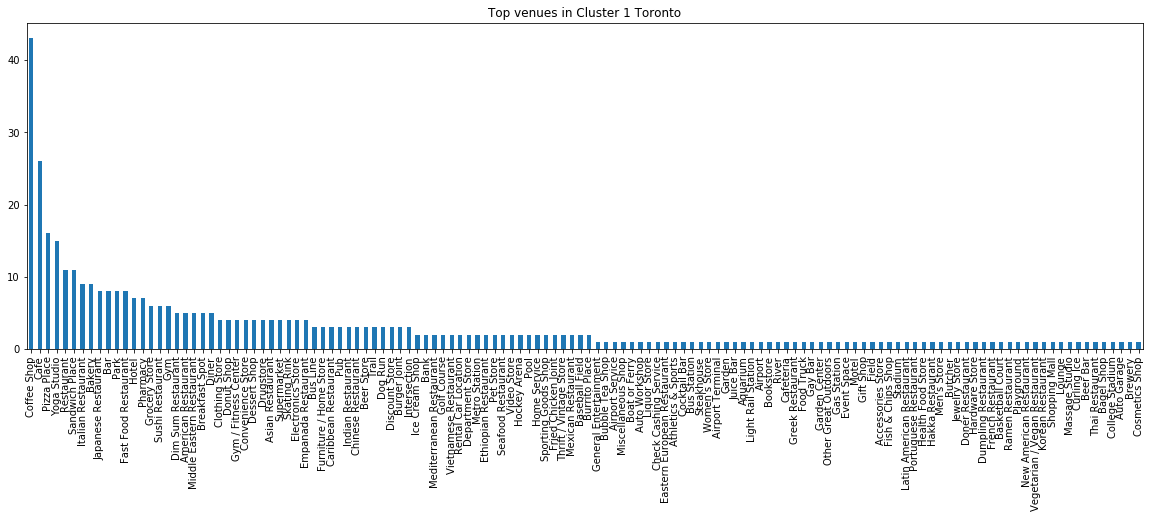

In [248]:
to_cluster1 = to_merged.loc[to_merged['Cluster Labels'] == 1, to_merged.columns[[1]+list(range(5, to_merged.shape[1]))]]

to_cluster1_flatten = to_cluster1.drop('Neighborhood', axis=1).reset_index(drop=True).melt()

fig = plt.figure()
to_cluster1_flatten['value'].value_counts().plot(kind='bar',figsize=(20,6))
plt.title('Top venues in Cluster 1 Toronto')

plt.show()

In [386]:
print('There are {} coffee shop in Cluster 1' .format(to_cluster1_flatten[(to_cluster1_flatten['value'] == 'Coffee Shop')].shape[0]))
print('There are {} café in Cluster 1' .format(to_cluster1_flatten[(to_cluster1_flatten['value'] == 'Café')].shape[0]))

There are 43 coffee shop in Cluster 1
There are 26 café in Cluster 1


Coffee shop and cafe are the two most common venues in Cluster 1. There is a fun theory that shows store owners tend to open their stores next to their competiters. There is an article that discusses about it, which may be interesting, but we will not cover it here for the sake of briefness. If you are interested, you can see it click [here](https://theamericangenius.com/business-news/three-theories-prove-why-competitors-open-stores-next-to-each-other/). But it is also possible to take the opposite approach which is to open a store in a neighborhood without coffee shop and cafe or with coffee shops and cafes but don't work very well. In this case, we can open the cafe in the Neighborhood inside Cluster 0,2,3 or 4.

Supposedly, we take the first approach since we know that people will go to this neighborhood to eat. We want to open the cafe in a neighborhood that has already restaurants, but the coffee shops and cafes are not popular.

In [354]:
columns = ['Neighborhood', 'Venue']
to_cluster1_fold = pd.DataFrame(columns = columns)

for idx in np.arange(to_cluster1.shape[0]):
    lst = to_cluster1.iloc[idx].values.tolist()
    for item in lst[1:]:
        to_cluster1_fold.loc[len(to_cluster1_fold.index)] = [lst[0],item]
    
to_cluster1_onehot = pd.get_dummies(to_cluster1_fold['Venue'], prefix="", prefix_sep="")
to_cluster1_onehot['Neighborhood'] = to_cluster1_fold['Neighborhood']

temp_columns = [to_cluster1_onehot.columns[-1]] + list(to_cluster1_onehot.columns[:-1])
to_cluster1_onehot = to_cluster1_onehot[temp_columns]
to_cluster1_onehot.head()

,Neighborhood,Accessories Store,Airport,Airport Service,Airport Terminal,American Restaurant,Aquarium,Asian Restaurant,Athletics & Sports,Auto Garage,...,Supermarket,Sushi Restaurant,Thai Restaurant,Thrift / Vintage Store,Trail,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Women's Store,Yoga Studio
0,"Rouge,Malvern",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"Rouge,Malvern",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"Rouge,Malvern",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"Rouge,Malvern",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"Rouge,Malvern",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [427]:
to_cluster1_onehot_mean = to_cluster1_onehot.groupby('Neighborhood').mean()
neighborhood_list = list(to_cluster1_onehot_mean[(to_cluster1_onehot_mean['Coffee Shop'] == 0) & (to_cluster1_onehot_mean['Café'] == 0)].index)
neighborhood_list

['Agincourt',
 'Albion Gardens,Beaumond Heights,Humbergate,Jamestown,Mount Olive,Silverstone,South Steeles,Thistletown',
 'Business Reply Mail Processing Centre 969 Eastern',
 'CN Tower,Bathurst Quay,Island airport,Harbourfront West,King and Spadina,Railway Lands,South Niagara',
 'Cedarbrae',
 'Clairlea,Golden Mile,Oakridge',
 "Clarks Corners,Sullivan,Tam O'Shanter",
 'Cliffcrest,Cliffside,Scarborough Village West',
 'Cloverdale,Islington,Martin Grove,Princess Gardens,West Deane Park',
 'Davisville North',
 'Don Mills North',
 'Dorset Park,Scarborough Town Centre,Wexford Heights',
 'Dovercourt Village,Dufferin',
 'Downsview Central',
 'Downsview Northwest',
 'Forest Hill North,Forest Hill West',
 'Glencairn',
 'Guildwood,Morningside,West Hill',
 'Hillcrest Village',
 'Humber Summit',
 'Humewood-Cedarvale',
 'Kingsway Park South West,Mimico NW,The Queensway West,Royal York South West,South of Bloor',
 'Little Portugal,Trinity',
 'Maryvale,Wexford',
 'Northwest',
 'Parkdale,Roncesvalles'

Okay, so now we have the list all neighborhoods which are in the cluster, that means they are the 'food' neighborhoods, but the coffee shop and cafe are not popular yet or they are not in these neighborhoods. And we know that there are 43 coffee shops and 26 café in this cluster, which means they are potential neighborhood.

### Now it's New York turn for analysis

For New York, we will limit the study to Manhattan to simplify some things.

In [377]:
manhattan_data = newyork_df[newyork_df['Borough'] == 'Manhattan']
manhattan_venues = getNearbyVenues(names = manhattan_data['Neighborhood'],
                            latitudes = manhattan_data['Latitude'],
                            longitudes = manhattan_data['Longitude']
                           )
manhattan_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Marble Hill,40.876551,-73.91066,Arturo's,40.874412,-73.910271,Pizza Place
1,Marble Hill,40.876551,-73.91066,Bikram Yoga,40.876844,-73.906204,Yoga Studio
2,Marble Hill,40.876551,-73.91066,Tibbett Diner,40.880404,-73.908937,Diner
3,Marble Hill,40.876551,-73.91066,Starbucks,40.877531,-73.905582,Coffee Shop
4,Marble Hill,40.876551,-73.91066,Dunkin',40.877136,-73.906666,Donut Shop


In [387]:
len(manhattan_venues['Venue Category'].unique())

339

In [388]:
# one hot encoding
manhattan_onehot = pd.get_dummies(manhattan_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
manhattan_onehot['Neighborhood'] = manhattan_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [manhattan_onehot.columns[-1]] + list(manhattan_onehot.columns[:-1])
manhattan_onehot = manhattan_onehot[fixed_columns]

manhattan_onehot.head()

,Neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,...,Vietnamese Restaurant,Volleyball Court,Waterfront,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Marble Hill,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Marble Hill,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,Marble Hill,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Marble Hill,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Marble Hill,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [389]:
manhattan_grouped = manhattan_onehot.groupby('Neighborhood').mean().reset_index()
manhattan_grouped.head()

,Neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,...,Vietnamese Restaurant,Volleyball Court,Waterfront,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Battery Park City,0.0,0.0,0.0,0.000000,0.010101,0.0,0.0,0.0,0.00,...,0.00,0.0,0.0,0.0,0.0,0.00,0.030303,0.0,0.010101,0.00
1,Carnegie Hill,0.0,0.0,0.0,0.000000,0.010000,0.0,0.0,0.0,0.01,...,0.02,0.0,0.0,0.0,0.0,0.01,0.030000,0.0,0.010000,0.03
2,Central Harlem,0.0,0.0,0.0,0.046512,0.046512,0.0,0.0,0.0,0.00,...,0.00,0.0,0.0,0.0,0.0,0.00,0.000000,0.0,0.000000,0.00
3,Chelsea,0.0,0.0,0.0,0.000000,0.030000,0.0,0.0,0.0,0.00,...,0.00,0.0,0.0,0.0,0.0,0.00,0.020000,0.0,0.010000,0.00
4,Chinatown,0.0,0.0,0.0,0.000000,0.040000,0.0,0.0,0.0,0.00,...,0.03,0.0,0.0,0.0,0.0,0.00,0.000000,0.0,0.000000,0.00


In [390]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))
        
ny_venues_sorted = pd.DataFrame(columns=columns)
ny_venues_sorted['Neighborhood'] = manhattan_grouped['Neighborhood']
for ind in np.arange(manhattan_grouped.shape[0]):
    ny_venues_sorted.iloc[ind, 1:] = return_most_common_venues(manhattan_grouped.iloc[ind, :], num_top_venues)
ny_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Battery Park City,Park,Coffee Shop,Hotel,Gym,Clothing Store
1,Carnegie Hill,Coffee Shop,Pizza Place,Café,Cosmetics Shop,Bar
2,Central Harlem,Chinese Restaurant,French Restaurant,American Restaurant,Cosmetics Shop,Bar
3,Chelsea,Coffee Shop,Bakery,Italian Restaurant,Ice Cream Shop,Theater
4,Chinatown,Chinese Restaurant,Cocktail Bar,American Restaurant,Salon / Barbershop,Vietnamese Restaurant


### Clustering neighborhood

In [391]:
kclusters = 5

manhattan_grouped_clustering = manhattan_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(manhattan_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([3, 1, 0, 0, 1, 0, 0, 4, 0, 0], dtype=int32)

In [392]:
# add clustering labels
ny_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [393]:
ny_venues_sorted

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,3,Battery Park City,Park,Coffee Shop,Hotel,Gym,Clothing Store
1,1,Carnegie Hill,Coffee Shop,Pizza Place,Café,Cosmetics Shop,Bar
2,0,Central Harlem,Chinese Restaurant,French Restaurant,American Restaurant,Cosmetics Shop,Bar
3,0,Chelsea,Coffee Shop,Bakery,Italian Restaurant,Ice Cream Shop,Theater
4,1,Chinatown,Chinese Restaurant,Cocktail Bar,American Restaurant,Salon / Barbershop,Vietnamese Restaurant
5,0,Civic Center,Gym / Fitness Center,Hotel,Coffee Shop,French Restaurant,Italian Restaurant
6,0,Clinton,Theater,Italian Restaurant,Coffee Shop,Gym / Fitness Center,American Restaurant
7,4,East Harlem,Mexican Restaurant,Thai Restaurant,Deli / Bodega,Bakery,Latin American Restaurant
8,0,East Village,Bar,Ice Cream Shop,Wine Bar,Mexican Restaurant,Pizza Place
9,0,Financial District,Coffee Shop,Bar,Gym,Hotel,Pizza Place


In [395]:
manhattan_merged = manhattan_data
manhattan_merged = manhattan_merged.join(ny_venues_sorted.set_index('Neighborhood'), on='Neighborhood').reset_index(drop=True)

manhattan_merged.head() # check the last columns!

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Manhattan,Marble Hill,40.876551,-73.910660,3,Coffee Shop,Sandwich Place,Yoga Studio,Bank,Big Box Store
1,Manhattan,Chinatown,40.715618,-73.994279,1,Chinese Restaurant,Cocktail Bar,American Restaurant,Salon / Barbershop,Vietnamese Restaurant
2,Manhattan,Washington Heights,40.851903,-73.936900,4,Café,Bakery,Grocery Store,Chinese Restaurant,Mobile Phone Shop
3,Manhattan,Inwood,40.867684,-73.921210,4,Café,Mexican Restaurant,Pizza Place,Bakery,Restaurant
4,Manhattan,Hamilton Heights,40.823604,-73.949688,4,Pizza Place,Deli / Bodega,Café,Coffee Shop,Mexican Restaurant


In [397]:
# create map
ny_addr = 'New York, NY'

ny_locator = Nominatim(user_agent="ny_explorer")
location= ny_locator.geocode(ny_addr)
latitude = location.latitude
longitude = location.longitude

map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(manhattan_merged['Latitude'], manhattan_merged['Longitude'], manhattan_merged['Neighborhood'], manhattan_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In contrast to Toronto, the neighborhoods in Manhattan have more distribution.

Let's check the cluster 0 first

In [398]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 0, manhattan_merged.columns[[1]+list(range(5, manhattan_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
6,Central Harlem,Chinese Restaurant,French Restaurant,American Restaurant,Cosmetics Shop,Bar
8,Upper East Side,Italian Restaurant,Exhibit,Bakery,Coffee Shop,Art Gallery
13,Lincoln Square,Theater,Plaza,Café,Concert Hall,Italian Restaurant
14,Clinton,Theater,Italian Restaurant,Coffee Shop,Gym / Fitness Center,American Restaurant
17,Chelsea,Coffee Shop,Bakery,Italian Restaurant,Ice Cream Shop,Theater
18,Greenwich Village,Italian Restaurant,Clothing Store,Sushi Restaurant,Indian Restaurant,French Restaurant
19,East Village,Bar,Ice Cream Shop,Wine Bar,Mexican Restaurant,Pizza Place
21,Tribeca,American Restaurant,Park,Italian Restaurant,Spa,Café
24,West Village,Italian Restaurant,New American Restaurant,Cosmetics Shop,Park,Wine Bar
27,Gramercy,Bar,Italian Restaurant,Mexican Restaurant,Pizza Place,Bagel Shop


In this cluster, the top venues are mostly restaurant and bar. But they have coffee shop and café too.
What about cluster 1?

In [399]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 1, manhattan_merged.columns[[1]+list(range(5, manhattan_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
1,Chinatown,Chinese Restaurant,Cocktail Bar,American Restaurant,Salon / Barbershop,Vietnamese Restaurant
10,Lenox Hill,Italian Restaurant,Coffee Shop,Pizza Place,Cocktail Bar,Sporting Goods Shop
12,Upper West Side,Italian Restaurant,Coffee Shop,Wine Bar,Bar,Mediterranean Restaurant
15,Midtown,Hotel,Coffee Shop,Sporting Goods Shop,Food Truck,Theater
16,Murray Hill,Coffee Shop,Hotel,Sandwich Place,American Restaurant,Japanese Restaurant
22,Little Italy,Bakery,Italian Restaurant,Café,Bubble Tea Shop,Cocktail Bar
23,Soho,Clothing Store,Boutique,Women's Store,Art Gallery,Shoe Store
30,Carnegie Hill,Coffee Shop,Pizza Place,Café,Cosmetics Shop,Bar
33,Midtown South,Korean Restaurant,Japanese Restaurant,Dessert Shop,Hotel,Hotel Bar
34,Sutton Place,Gym / Fitness Center,Italian Restaurant,Furniture / Home Store,Gym,Indian Restaurant


In [401]:
manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 3, manhattan_merged.columns[[1]+list(range(5, manhattan_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Marble Hill,Coffee Shop,Sandwich Place,Yoga Studio,Bank,Big Box Store
11,Roosevelt Island,Sandwich Place,Park,Coffee Shop,Gym / Fitness Center,Farmers Market
26,Morningside Heights,Park,Coffee Shop,Bookstore,American Restaurant,Deli / Bodega
28,Battery Park City,Park,Coffee Shop,Hotel,Gym,Clothing Store


In New York, apparently the coffee shops and cafés can be found at the top venues in cluster 0,1, and 3. We're going to check visually if a conclusion can be taken here.

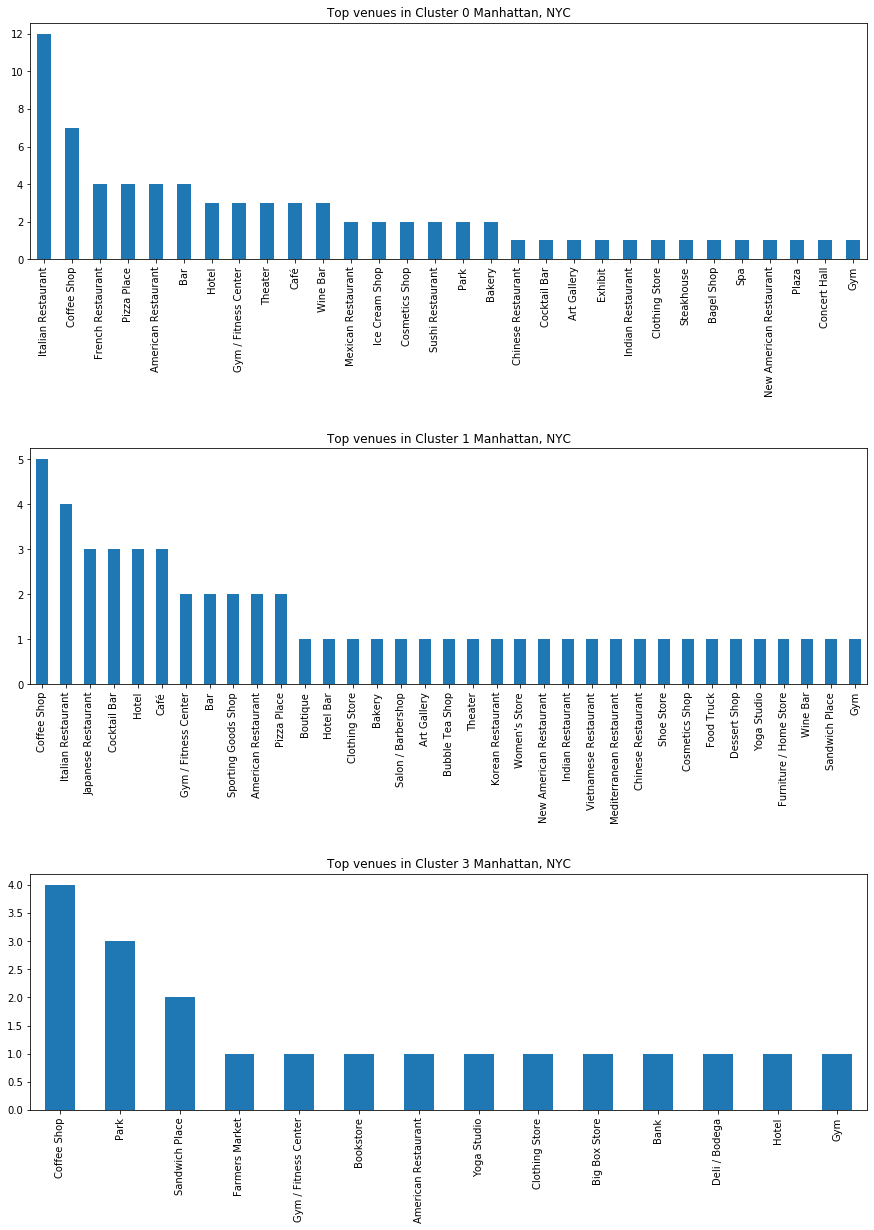

In [415]:
manhattan_cluster0 = manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 0, manhattan_merged.columns[[1]+list(range(5, manhattan_merged.shape[1]))]]
manhattan_cluster1 = manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 1, manhattan_merged.columns[[1]+list(range(5, manhattan_merged.shape[1]))]]
manhattan_cluster3 = manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 3, manhattan_merged.columns[[1]+list(range(5, manhattan_merged.shape[1]))]]

ma_cluster0_flatten = manhattan_cluster0.drop('Neighborhood', axis=1).reset_index(drop=True).melt()
ma_cluster1_flatten = manhattan_cluster1.drop('Neighborhood', axis=1).reset_index(drop=True).melt()
ma_cluster3_flatten = manhattan_cluster3.drop('Neighborhood', axis=1).reset_index(drop=True).melt()

fig = plt.figure
plt.subplots_adjust(hspace=0.8)
plt.subplot(3,1,1)
ma_cluster0_flatten['value'].value_counts().plot(kind='bar',figsize=(15,20))
plt.title('Top venues in Cluster 0 Manhattan, NYC')
plt.subplot(3,1,2)
ma_cluster1_flatten['value'].value_counts().plot(kind='bar',figsize=(15,20))
plt.title('Top venues in Cluster 1 Manhattan, NYC')
plt.subplot(3,1,3)
ma_cluster3_flatten['value'].value_counts().plot(kind='bar',figsize=(15,20))
plt.title('Top venues in Cluster 3 Manhattan, NYC')

plt.show()

In Manhattan, the coffee shop and cafe location are more distributed and the numbers are much lower. There are only 16 coffee shops and 6 cafes in the list of top venues for the 3 clusters. Perhaps, there is another reason why it is like that. For an example, we will take the cluster 1 for the same analysis as Toronto.

In [416]:
columns = ['Neighborhood', 'Venue']
ma_cluster1_fold = pd.DataFrame(columns = columns)

for idx in np.arange(manhattan_cluster1.shape[0]):
    lst = manhattan_cluster1.iloc[idx].values.tolist()
    for item in lst[1:]:
        ma_cluster1_fold.loc[len(ma_cluster1_fold.index)] = [lst[0],item]
    
ma_cluster1_onehot = pd.get_dummies(ma_cluster1_fold['Venue'], prefix="", prefix_sep="")
ma_cluster1_onehot['Neighborhood'] = ma_cluster1_fold['Neighborhood']

temp_columns = [ma_cluster1_onehot.columns[-1]] + list(ma_cluster1_onehot.columns[:-1])
ma_cluster1_onehot = ma_cluster1_onehot[temp_columns]

ma_cluster1_onehot_mean = ma_cluster1_onehot.groupby('Neighborhood').mean()
neighborhood_list = list(ma_cluster1_onehot_mean[(ma_cluster1_onehot_mean['Coffee Shop'] == 0) & (ma_cluster1_onehot_mean['Café'] == 0)].index)
neighborhood_list

['Chinatown', 'Midtown South', 'Soho', 'Sutton Place']

In conclusion, Toronto has more coffee shops and cafés than Manhattan, NY, and they are more likely located in the same type of neighborhood. New York (Manhattan) has fewer coffee shops and cafés as the top venues since it has also many types of restaurants. As an example, I take one of the clusters in Manhattan and check which neighborhood is not famous for its coffee shops or cafés. It seems that they are not in the business centers. Perhaps, there are other reasons why people don't go to these neighborhoods for coffee shops. To really find the reasons, more data is needed.